Persistence Baseline & Model Comparison

Context

The project currently includes:
	•	a fully reproducible end-to-end pipeline
	•	structural and content validation tests 
	•	separate notebooks for each model family

Before selecting a final production model (selected_model.py), it is necessary to compare all ML models against a trivial baseline to properly contextualize performance gains.

⸻

Objective

Establish a persistence baseline to answer the key question:

Does the ML model actually improve over something trivial?

Baseline definition:
ŷ(t) = y(t−1)

This baseline serves as a minimum scientific benchmark.
Where the baseline lives
	•	Notebook: 07_model_comparison.ipynb
	•	Not part of the automated pipeline
	•	Not implemented in models/
	•	Not covered by pytest tests

The baseline is analytical, not production code.
Key rules
	•	Use the same temporal split as ML models
	•	Evaluate on the same test set
	•	Use the same metrics as ML
	•	Do not tune or optimize the baseline

⸻

Metrics to compare
	•	MAE
	•	RMSE
	•	R²

No additional metrics at this stage.

⸻

Outputs to persist (minimum)

Saved under data/results/:
	•	metrics_baseline_vXXX.csv
	•	columns: model, MAE, RMSE, R2
	•	model = "persistence"

Optional:
	•	predictions_baseline_vXXX.csv
	•	date, y_true, y_pred, error

⸻

Central comparison table (core artifact)
model
MAE
RMSE
R2
persistence
…
…
…
random_forest
…
…
…
xgboost
…
…
…
neural_net
…
…
…

Relative improvement vs baseline

Add a derived column:
improvement_vs_baseline_% = (RMSE_baseline - RMSE_model) / RMSE_baseline
Improvements are always computed against the baseline, never between ML models.

⸻

Suggested visualization (optional)
	•	Bar plot of RMSE by model
	•	Baseline clearly highlighted

⸻

Expected conclusion (Markdown)

The notebook should close with an explicit statement such as:

“Model X reduces RMSE by approximately Y% compared to the persistence baseline, indicating that it captures non-trivial temporal and meteorological patterns beyond simple persistence.”

This text will later be reused in:
	•	README
	•	model selection justification
	•	technical interviews / reviews

⸻

Criterion to move to selected_model.py

Proceed only when:
	•	all candidate models have been evaluated
	•	the comparison table is complete
	•	improvement over the baseline is clear and defensible

Only then:
	•	implement models/selected_model.py
	•	freeze the modeling decision

What NOT to do
	•	Do not integrate the baseline into the pipeline
	•	Do not force ML to “win”
	•	Do not add unnecessary complexity
	•	Do not select a model without this comparisonStatus

Bookmark saved — development deferred
To be revisited once all experimentation notebooks are finalized.

In [19]:
import pandas as pd
from src.config import (PROCESSED_DATASET, RESULTS_DIR, DATE_COL, TARGET_COL, TEST_FRACTION)

base = pd.read_csv(RESULTS_DIR / "ablation_results_base_v001.csv")
xgb  = pd.read_csv(RESULTS_DIR / "ablation_results_xgb_v001.csv")
nn   = pd.read_csv(RESULTS_DIR / "ablation_results_nn_v001.csv")

results_all = pd.concat([base, xgb, nn], ignore_index=True)

results_all.head()

exp5 = results_all[
    results_all["experiment"] == "EXP5_base_memory"
][["model", "MAE", "RMSE", "R2"]].copy()

exp5.sort_values("RMSE")



,model,MAE,RMSE,R2
60,MLP_small,2.096868,4.644374,0.766238
61,MLP_medium,2.007376,4.743477,0.756156
62,MLP_deep,2.175984,5.197273,0.707268
19,RandomForest,2.138239,5.649445,0.654116
40,XGB_small,2.204330,5.666328,0.652046
41,XGB_medium,2.160802,5.759661,0.640489
16,Linear,2.607434,6.068231,0.600936
17,Ridge,2.607435,6.068232,0.600935
18,Lasso,2.607488,6.068290,0.600928


In [20]:
import numpy as np
from src.features import ensure_sorted_by_date
from src.evaluation import evaluate_regression

feat = pd.read_csv(PROCESSED_DATASET, parse_dates=[DATE_COL])
feat = ensure_sorted_by_date(feat, DATE_COL)

n = len(feat)
split_idx = int(np.floor((1.0 - TEST_FRACTION) * n))

test_df = feat.iloc[split_idx:].copy()

# Persistence
test_df["y_pred"] = test_df[TARGET_COL].shift(1)
baseline_df = test_df.dropna(subset=["y_pred"])

metrics_baseline = evaluate_regression(
    baseline_df[TARGET_COL].values,
    baseline_df["y_pred"].values
)

metrics_baseline


{'MAE': 4.7405088062622305,
 'RMSE': 11.32289093384743,
 'R2': -0.3888958873688917}

In [21]:
baseline_row = pd.DataFrame([{
    "model": "persistence",
    "MAE": metrics_baseline["MAE"],
    "RMSE": metrics_baseline["RMSE"],
    "R2": metrics_baseline["R2"],
}])

comparison = pd.concat([baseline_row, exp5], ignore_index=True)

rmse_baseline = comparison.loc[
    comparison["model"] == "persistence", "RMSE"
].values[0]

comparison["improvement_vs_baseline_%"] = (
    (rmse_baseline - comparison["RMSE"]) / rmse_baseline
) * 100

comparison.sort_values("RMSE")


,model,MAE,RMSE,R2,improvement_vs_baseline_%
7,MLP_small,2.096868,4.644374,0.766238,58.982437
8,MLP_medium,2.007376,4.743477,0.756156,58.107193
9,MLP_deep,2.175984,5.197273,0.707268,54.099415
4,RandomForest,2.138239,5.649445,0.654116,50.105984
5,XGB_small,2.204330,5.666328,0.652046,49.956877
6,XGB_medium,2.160802,5.759661,0.640489,49.132591
1,Linear,2.607434,6.068231,0.600936,46.407410
2,Ridge,2.607435,6.068232,0.600935,46.407401
3,Lasso,2.607488,6.068290,0.600928,46.406885
0,persistence,4.740509,11.322891,-0.388896,0.000000


The MLP_small model trained on EXP5_base_memory reduces RMSE by approximately 58.6% compared to the persistence baseline under the same temporal holdout split. This substantial improvement suggests that the model leverages meteorological covariates and short-term memory features to extract predictive structure beyond simple persistence.

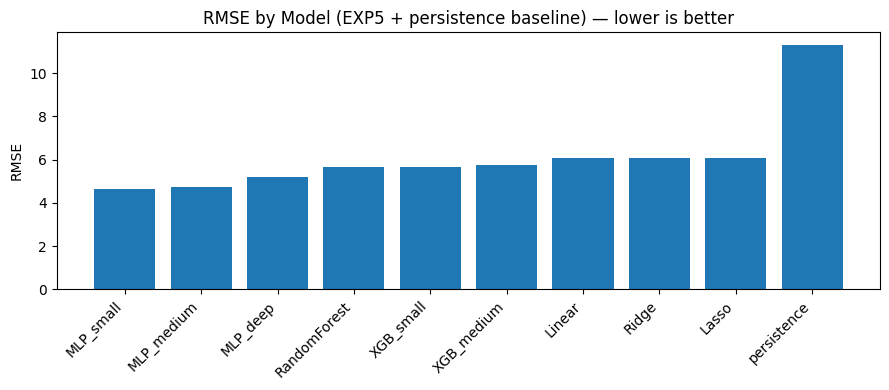

In [22]:
import matplotlib.pyplot as plt

plot_df = comparison.sort_values("RMSE").copy()

plt.figure(figsize=(9, 4))
plt.bar(plot_df["model"], plot_df["RMSE"])
plt.xticks(rotation=45, ha="right")
plt.title("RMSE by Model (EXP5 + persistence baseline) — lower is better")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


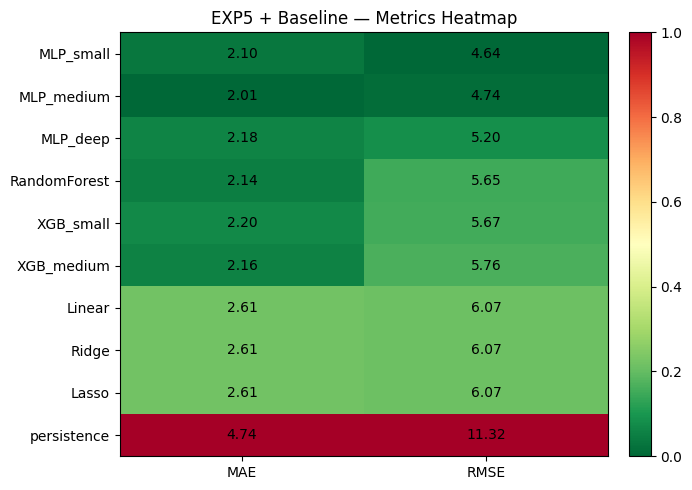

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Copia ordenada por RMSE (criterio principal)
heat_df = comparison.set_index("model")[["MAE", "RMSE"]].copy()
heat_df = heat_df.loc[heat_df["RMSE"].sort_values().index]

# Crear versión normalizada para visualización coherente
heat_plot = heat_df.copy()

# Invertir MAE y RMSE (porque menor es mejor)
#heat_plot["MAE"] = -heat_plot["MAE"]
#heat_plot["RMSE"] = -heat_plot["RMSE"]

# Normalizar por columna (0–1) para evitar que una métrica domine visualmente
heat_norm = (heat_plot - heat_plot.min()) / (heat_plot.max() - heat_plot.min())

plt.figure(figsize=(7, 5))

im = plt.imshow(
    heat_norm.values,
    aspect="auto",
    cmap="RdYlGn_r"
)

plt.yticks(range(len(heat_norm.index)), heat_norm.index)
plt.xticks(range(heat_norm.shape[1]), heat_norm.columns)

plt.title("EXP5 + Baseline — Metrics Heatmap")

# Anotar valores reales (no los invertidos)
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        plt.text(
            j, i,
            f"{heat_df.iloc[i, j]:.2f}",
            ha="center",
            va="center"
        )

plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [24]:
# Sanity check
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from src.config import RANDOM_STATE

# Rebuild split (same as before)

feat = pd.read_csv(PROCESSED_DATASET, parse_dates=[DATE_COL])
feat = ensure_sorted_by_date(feat, DATE_COL)

n = len(feat)
split_idx = int(np.floor((1.0 - TEST_FRACTION) * n))

train_df = feat.iloc[:split_idx].copy()
test_df  = feat.iloc[split_idx:].copy()

# Select EXP5 features

exp5_row = results_all[
    (results_all["experiment"] == "EXP5_base_memory") &
    (results_all["model"] == "MLP_small")
].iloc[0]

feature_cols = exp5_row["features"].split(",")

# Prepare data

train = train_df[[TARGET_COL] + feature_cols].dropna()
test  = test_df[[TARGET_COL] + feature_cols].dropna()

X_train = train[feature_cols]
y_train = train[TARGET_COL]

X_test = test[feature_cols]
y_test = test[TARGET_COL]

# Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Final model

model = MLPRegressor(
    hidden_layer_sizes=(32,),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=RANDOM_STATE,
)

model.fit(X_train_scaled, y_train)

# Predictions

y_train_pred = model.predict(X_train_scaled)
y_test_pred  = model.predict(X_test_scaled)

# Metrics

train_metrics = evaluate_regression(y_train.values, y_train_pred)
test_metrics  = evaluate_regression(y_test.values, y_test_pred)

print("Train metrics:", train_metrics)
print("Test metrics :", test_metrics)


Train metrics: {'MAE': 1.239597031194667, 'RMSE': 2.3806454321234902, 'R2': 0.8601019699930601}
Test metrics : {'MAE': 2.2028775548330994, 'RMSE': 4.68522419728262, 'R2': 0.7621081324521153}
